In [2]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0

     |████████████████████████████████| 377 kB 188 kB/s eta 0:00:01
     |████████████████████████████████| 50 kB 3.0 MB/s eta 0:00:011
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 421.8 MB 22 kB/s  eta 0:00:014     |████████████████████▌           | 270.8 MB 19.5 MB/s eta 0:00:08     |████████████████████▉           | 275.3 MB 19.5 MB/s eta 0:00:08��████████████████████▍          | 281.6 MB 444 kB/s eta 0:05:16     |█████████████████████▌          | 283.0 MB 444 kB/s eta 0:05:13     |█████████████████████████████▏  | 384.7 MB 10.5 MB/s eta 0:00:04
     |████████████████████████████████| 448 kB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 14.1 MB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.wh

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow-probability 0.11.0 requires gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [67]:
import tensorflow
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam, schedules
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
!pip install -U git+https://github.com/qubvel/efficientnet
import efficientnet.keras as efn

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-gnoo54ve
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18397 sha256=9a8467e69cd53b8bcd109832478700cab02efea0c4f824594a1b38509a65c3d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ag6gfnn3/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [31]:
# batch size
bs = 8
image_path='../input/covidx-v3/data'
# Train csv
train=pd.read_csv('../input/covid-net-csv/train.csv',dtype=str)
# Test csv
test=pd.read_csv('../input/covid-net-csv/test.csv',dtype=str)

In [32]:
datagen = ImageDataGenerator(rescale=1./255)

# Train data generator
train_generator = datagen.flow_from_dataframe(
                                                dataframe = train, 
                                                directory = image_path+'/train', 
                                                x_col = 'image', 
                                                y_col = 'target', 
                                                batch_size = bs,
                                                shuffle =True,
                                                seed = 1,
                                                class_mode = 'categorical',
                                                target_size = (512,512)
                                                )


# Test data generator
test_generator =  datagen.flow_from_dataframe(
                                                  dataframe=test,
                                                  directory=image_path+'/test',
                                                  x_col='image',
                                                  y_col='target',
                                                  batch_size=1, #preffered 1
                                                  shuffle=False,
                                                  class_mode='categorical',
                                                  target_size=(512,512))

Found 13898 validated image filenames belonging to 3 classes.
Found 1579 validated image filenames belonging to 3 classes.


**Example images from Dataset**

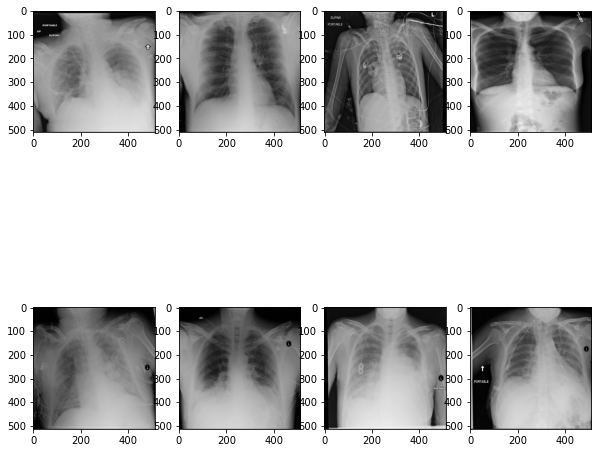

In [33]:
axes = []
fig = plt.figure(figsize = (10,10))
x = next(train_generator)
for i in range(8):
    axes.append(fig.add_subplot(2,4,i+1))
    plt.imshow(x[0][i])
plt.show()

In [34]:
print("Train")
print('--------------------------')
print(train.target.value_counts())
print('--------------------------')
print("Test")
print('--------------------------')
print(test.target.value_counts())
print('--------------------------')

Train
--------------------------
normal       7966
pneumonia    5459
COVID-19      473
Name: target, dtype: int64
--------------------------
Test
--------------------------
normal       885
pneumonia    594
COVID-19     100
Name: target, dtype: int64
--------------------------


In [35]:
# Computing classweights for the three classes
# Classweights are used in imbalanced datasets
# The minority classes have high weights compared to majority classes, this is done to limit weight updates from majority classes 
from sklearn.utils import class_weight
y_2=np.array([0] * 473 + [1] * 7966 + [2]*5459)
classweights=class_weight.compute_class_weight('balanced',[0,1,2],y_2)
print(classweights)

[9.79422128 0.58155494 0.84862918]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1, 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [15]:
# EfficientNet-B1 Model
def eff_model():
    base_model=efn.EfficientNetB1(weights='imagenet',include_top=False,pooling='avg',input_shape=(512,512,3))
    x = Dropout(0.6)(base_model.output)
    x = Dense(3,activation='softmax')(x)

    
    model = Model(base_model.input,x)
    #lr_schedule = schedules.ExponentialDecay(initial_learning_rate=1e-3,decay_steps = 6944,decay_rate = 0.5,staircase = True)
    opt = Adam(learning_rate=1e-3,amsgrad=True)
    #cat_crossentropy = Keras.losses.CategoricalCrossentropy(label_smoothing = 0.1)
    model.compile(optimizer = opt,loss = 'categorical_crossentropy', metrics=['accuracy'])
    return model

In [29]:
model = eff_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

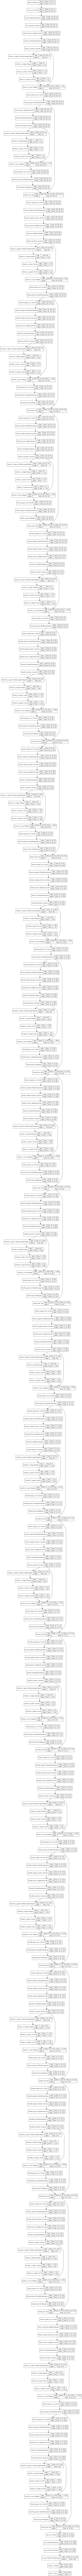

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes = True, show_layer_names = True)

In [36]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size

# Already calculated - this would make model to learn more from samples which low in number in our case - Covid
classweights={0: 9.7942,
             1:0.56155,
             2:0.90000}

model=eff_model()
model.fit_generator(
                    train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=7,
                    class_weight=classweights,
                    verbose=1
                    )

model.save_weights(f'/kaggle/working/model_B1_epoch_7.h5')



Epoch 1/7
1737/1737 [==============================] - 1103s 635ms/step - loss: 0.5125 - accuracy: 0.7821
Epoch 2/7
1737/1737 [==============================] - 1084s 624ms/step - loss: 0.2663 - accuracy: 0.8832
Epoch 3/7
1737/1737 [==============================] - 1083s 623ms/step - loss: 0.2407 - accuracy: 0.9000
Epoch 4/7
1737/1737 [==============================] - 1076s 619ms/step - loss: 0.1739 - accuracy: 0.9228
Epoch 5/7
1737/1737 [==============================] - 1082s 623ms/step - loss: 0.1265 - accuracy: 0.9402
Epoch 6/7
1737/1737 [==============================] - 1082s 623ms/step - loss: 0.1414 - accuracy: 0.9372
Epoch 7/7
1737/1737 [==============================] - 1079s 621ms/step - loss: 0.1140 - accuracy: 0.9505


In [40]:
model.load_weights('../input/best-model-covid/best_model_B1_7_epochs.h5')

In [64]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
pred=model.predict_generator(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)

predictions = np.argmax(pred,axis = 1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = np.array([labels[k] for k in predictions])

test_target = test.target.values
accuracy = (np.sum(test_target == predictions))/1579
print("Accuracy --> ", accuracy)

1579/1579 [==============================] - 49s 31ms/step
Accuracy -->  0.954401519949335


In [65]:
from sklearn.metrics import classification_report
print(classification_report(test_target,predictions,labels=["COVID-19", "normal", "pneumonia"]))

              precision    recall  f1-score   support

    COVID-19       0.94      1.00      0.97       100
      normal       0.97      0.95      0.96       885
   pneumonia       0.94      0.95      0.94       594

    accuracy                           0.95      1579
   macro avg       0.95      0.97      0.96      1579
weighted avg       0.95      0.95      0.95      1579



In [66]:
y_test =test_generator.classes
nb_samples = len(y_test)
pred = model.predict_generator(test_generator, nb_samples)
pred = np.argmax(pred, axis=1)

matrix = confusion_matrix(y_test, pred)
matrix = matrix.astype('float')
#cm_norm = matrix / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


class_acc = [matrix[i,i]/np.sum(matrix[i,:]) if np.sum(matrix[i,:]) else 0 for i in range(len(matrix))]
print('Sens covid: {0:.3f}, Normal: {1:.3f}, pneumonia : {2:.3f}'.format(class_acc[0],class_acc[1],class_acc[2]))
ppvs = [matrix[i,i]/np.sum(matrix[:,i]) if np.sum(matrix[:,i]) else 0 for i in range(len(matrix))]
print('PPV :covid {0:.3f}, Normal {1:.3f}, pneumonia: {2:.3f}'.format(ppvs[0],ppvs[1],ppvs[2]))

Sens covid: 1.000, Normal: 0.955, pneumonia : 0.946
PPV :covid 0.943, Normal 0.969, pneumonia: 0.935


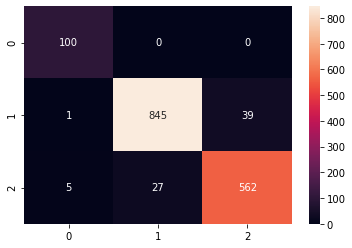

In [68]:
matrix = confusion_matrix(test_target, predictions, labels=["COVID-19", "normal", "pneumonia"])
sns.heatmap(matrix,annot = True,fmt = "d")